1. Difficulty evaluation using trajectory rewards

Visualization of the state

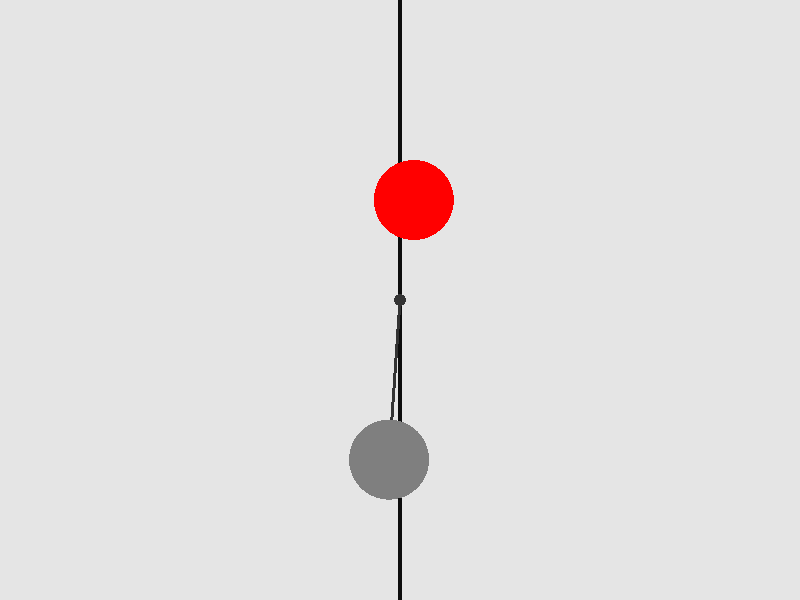

In [1]:
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import mean, running_average

env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)

### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [2]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

Pendulum(angle: -0.34, angular_speed: -0.05, vertical_position: 0.00, enemies: 0.25)
difficulty: 0.425


### Difficulty estimation using trajectory rewards

In [3]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

tensor([0.6693, 0.9592, 0.1732, 0.2468, 0.5880, 0.7313, 0.8509, 0.8748, 0.9289,
        0.0514])

### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [4]:
agents = []
agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
total_rewards = []

Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

loss: 647.903564453125. Mean total reward: -47.52000000000002


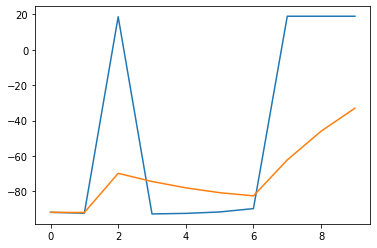

In [5]:
# Train the agent for N iterations
loss = agent.train(env, epochs=100, max_trajectory_length=20)

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [10]:
# Use this to append an agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")

Total of: 4 agents


Now we have our agents, let's run the evaluator

In [11]:
weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())


tensor(-0.7105)